<a href="https://colab.research.google.com/github/Ehsan1997/VAE-Pytorch-Colab/blob/master/Pytorch_VAE_SS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [ ]:
import torch
import torchvision
import numpy as np
import tqdm
import matplotlib.pyplot as plt

### Device Handling

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Reproducability

In [ ]:
seed = 0
torch.manual_seed(seed)
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
np.random.seed(seed)

### Configuration Variables

In [ ]:
batch_size = 64
# Beta value for disentangled VAE
beta = 1
# Number of epochs
num_epoch = 10
# Latent Dimension
latent_dim = 16
# Image Dimensions
im_w, im_h = 28, 28

### Utils

In [ ]:
def get_preloaded_dataset(dataset_class, transform,
                          batch_size, test_transform=None, shuffle=True):
  """
  Load the preloaded dataset available with pytorch.
  
  Args:
  dataset_class -> class of the preloaded dataset
  transform -> Composed Transforms to apply to the image
  batch_size -> Number of images per batch
  test_transform -> Different Transforms for test dataset,
                  if None, transform is used.
  shuffle -> Shuffle training data after each epoch or not.

  Returns:
  Train and test dataloaders
  """
  # If test_transform not specified, used transform
  if not test_transform:
    test_transform = transform
  train_dataset = dataset_class('data', download=True,
                                transform=transform)
  test_dataset = dataset_class('data', download=True,
                               transform=test_transform)
  train_loader = torch.utils.data.DataLoader(train_dataset, 
                                             batch_size=batch_size,
                                             shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
  
  return train_loader, test_loader

In [ ]:
def show_image_batch(img_batch):
  n_col = 8
  for i in range(0, img_batch.shape[0], n_col):
    imgs = img_batch[i:i+n_col]
    _, axs = plt.subplots(1, imgs.shape[0], figsize=(12, 12))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
      ax.imshow(img, cmap='gray')
      ax.set_axis_off()
    plt.show()

In [ ]:
def tensor_to_image(image_tensor):
  img = image_tensor[0].detach().cpu().numpy()
  img = img.transpose(0,2,3,1)
  img = np.squeeze(img, -1)

  return img

### Data Loading

In [ ]:
transform = torchvision.transforms.Compose([
                                             torchvision.transforms.ToTensor()
                                             ])
train_loader, test_loader = get_preloaded_dataset(torchvision.datasets.MNIST,
                                                  transform, batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Neural Network Definition

In [ ]:
class Encoder(torch.nn.Module):
  """
  Encoder for the variational Encoder
  """
  def __init__(self, in_channels=1, hidden_dims=16):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=16,
                                 kernel_size=3, stride=2, padding=1)
    self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                                 kernel_size=3, stride=2, padding=1)
    self.fc_mu = torch.nn.Linear(in_features=32*7*7, out_features=hidden_dims)
    self.fc_logvar = torch.nn.Linear(in_features=32*7*7,
                                     out_features=hidden_dims)
    
  def forward(self, x):
    x = torch.nn.ReLU()(self.conv1(x))
    x = torch.nn.ReLU()(self.conv2(x))
    x = x.view(x.shape[0], -1)
    x_mu = self.fc_mu(x)
    x_logvar = self.fc_logvar(x)

    return x_mu, x_logvar

In [ ]:
class Decoder(torch.nn.Module):
  """
  Decoder for variational Auto-Encoder
  """
  def __init__(self, in_channels=1, hidden_dims=16):
    super().__init__()
    self.fc = torch.nn.Linear(in_features=hidden_dims, out_features=32*7*7)
    self.conv1 = torch.nn.ConvTranspose2d(in_channels=32, out_channels=16,
                                          kernel_size=3, stride=2,
                                          padding=1, output_padding=1)
    self.conv2 = torch.nn.ConvTranspose2d(in_channels=16, 
                                          out_channels=in_channels,
                                          kernel_size=3, stride=2, 
                                          padding=1, output_padding=1)
    
  def forward(self, x):
    x = self.fc(x)
    x = x.view(x.shape[0], 32, 7,7)
    x = torch.nn.ReLU()(self.conv1(x))
    x = self.conv2(x)

    return x

In [ ]:
class VariationalAutoEncoder(torch.nn.Module):
  def __init__(self, in_channels=1, hidden_dims=16):
    super().__init__()
    self.encoder = Encoder(in_channels=in_channels, hidden_dims=hidden_dims)
    self.decoder= Decoder(in_channels=in_channels, hidden_dims=hidden_dims)

  def forward(self, x):
    x_mu, x_logvar = self.encoder(x)
    z = self.latent_sample(x_mu, x_logvar)
    x = self.decoder(z)
    
    return x, x_mu, x_logvar

  def latent_sample(self, x_mu, x_logvar):
    if self.training:
      # Reparameterization Trick
      std = x_logvar.mul(0.5).exp()
      eps = torch.empty_like(std).normal_()
    
      return eps.mul(std).add(x_mu)

    else:
      return x_mu


#### Loss definition

In [ ]:
def vae_loss(y_true, y_pred, mu, logvar):
  mse_loss = torch.nn.MSELoss(reduction='sum')
  reconstruction_loss = mse_loss(y_true.view(-1, im_w*im_h), y_pred.view(-1, im_w*im_h))
  kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

  return reconstruction_loss + beta * kld_loss

### Training

In [ ]:
vae = VariationalAutoEncoder(hidden_dims=latent_dim)
vae.to(device)

VariationalAutoEncoder(
  (encoder): Encoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (fc_mu): Linear(in_features=1568, out_features=16, bias=True)
    (fc_logvar): Linear(in_features=1568, out_features=16, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=16, out_features=1568, bias=True)
    (conv1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (conv2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Set VAE to train mode
vae.train()
# Keep records of loss for each epoch
loss_list = []
# Number of batches
num_batches = len(train_loader)


for epoch in range(num_epoch):
  loss_list.append(0)

  with tqdm.tqdm(total=num_batches) as pbar:  
    for i, (image_batch, _) in enumerate(train_loader):
      # Move image_batch to GPU if available
      image_batch = image_batch.to(device)
      # Get Output of VAE
      reconstructed_image_batch, mu, logvar = vae(image_batch)
      # Get Loss of VAE
      loss = vae_loss(reconstructed_image_batch, image_batch, mu, logvar)
      # Set gradients to zero
      optimizer.zero_grad()
      # Perform backpropagation
      loss.backward()
      # Update Weights
      optimizer.step()
      # Add loss of current batch to total loss
      loss_list[-1] += loss.item()
      # Update the loading bar
      pbar.update(1)
      pbar.set_description(f"Epoch: [{epoch+1}/{num_epoch}],\t Loss: {loss_list[-1]/(i+1)}\t")
    # Average of the loss over all the batches
    loss_list[-1] /= num_batches


Epoch: [10/10],	 Loss: 2043.9056650255282	: 100%|██████████| 938/938 [00:32<00:00, 28.75it/s]


In [ ]:
# Save Model Weights
torch.save(vae.state_dict(), '/content/drive/My Drive/DeepLearning/PytorchVAE/vae_10.pt')

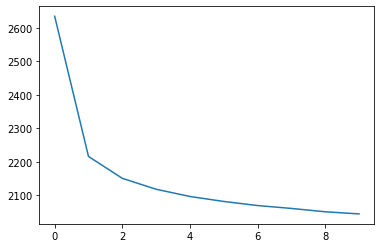

In [ ]:
# Visualize loss plot
plt.plot(loss_list)
plt.show()

### Inference

In [ ]:
vae.load_state_dict(
    torch.load('/content/drive/My Drive/DeepLearning/PytorchVAE/vae_10.pt')
    )

<All keys matched successfully>

In [ ]:
vae.eval()
with torch.no_grad():
  image_tensor = vae(next(iter(test_loader))[0].to(device))
img = tensor_to_image(image_tensor)

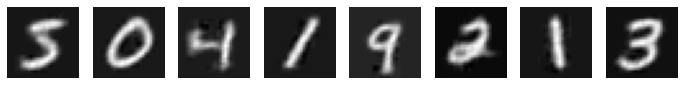

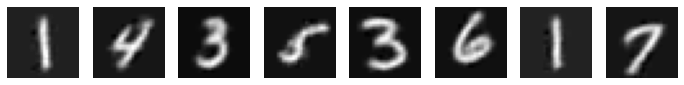

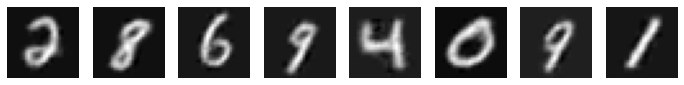

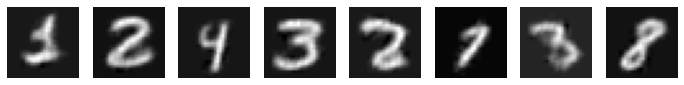

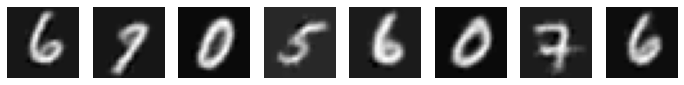

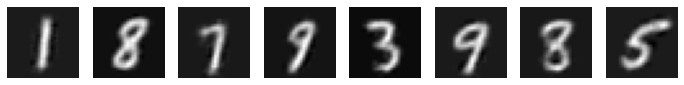

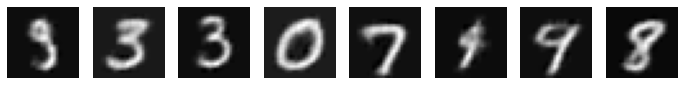

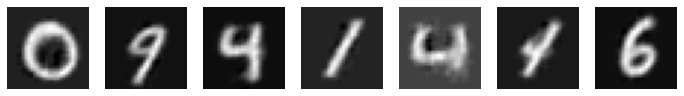

In [ ]:
show_image_batch(img[:-1])